In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

from epam.torch_common import pick_device

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 67458 training examples and 16864 validation examples


In [8]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
# burrito = noof.NoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 12.291797	 Val Loss: 11.07848
Epoch [2/3]	 Loss: 10.946132	 Val Loss: 10.424766
Epoch [3/3]	 Loss: 10.496413	 Val Loss: 10.152308


AttributeError: 'NoofBurrito' object has no attribute 'write_shmoof_output'

In [ ]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=3)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)

Training with regularization coefficient 0
Epoch [1/3]	 Loss: 10.29742553	 Val Loss: 10.32518021
Epoch [2/3]	 Loss: 10.30215282	 Val Loss: 10.38673430
Epoch [3/3]	 Loss: 10.31676918	 Val Loss: 10.39607931
Training with regularization coefficient 1e-08
Epoch [1/3]	 Loss: 10.28193137	 Val Loss: 10.29404392
Epoch [2/3]	 Loss: 10.24075869	 Val Loss: 10.29550941
Epoch [3/3]	 Loss: 10.24111233	 Val Loss: 10.29608725
Training with regularization coefficient 1e-07
Epoch [1/3]	 Loss: 10.27166113	 Val Loss: 10.28128177
Epoch [2/3]	 Loss: 10.22769979	 Val Loss: 10.28084045
Epoch [3/3]	 Loss: 10.22703252	 Val Loss: 10.28101847
Training with regularization coefficient 1e-06
Epoch [1/3]	 Loss: 10.25202845	 Val Loss: 10.25605963
Epoch [2/3]	 Loss: 10.20131101	 Val Loss: 10.25311612
Epoch [3/3]	 Loss: 10.19869179	 Val Loss: 10.25196464
Training with regularization coefficient 1e-05
Epoch [1/3]	 Loss: 10.21306235	 Val Loss: 10.21156708
Epoch [2/3]	 Loss: 10.15475340	 Val Loss: 10.20520857
Epoch [3/3]	 

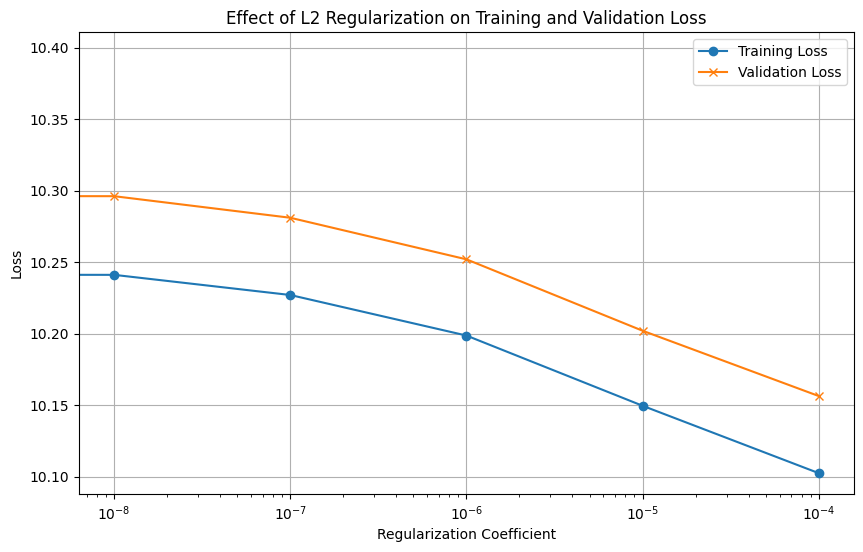

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


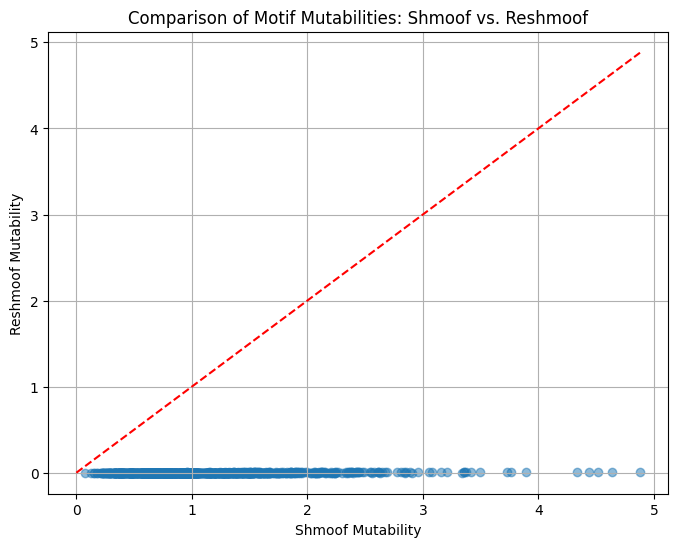

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

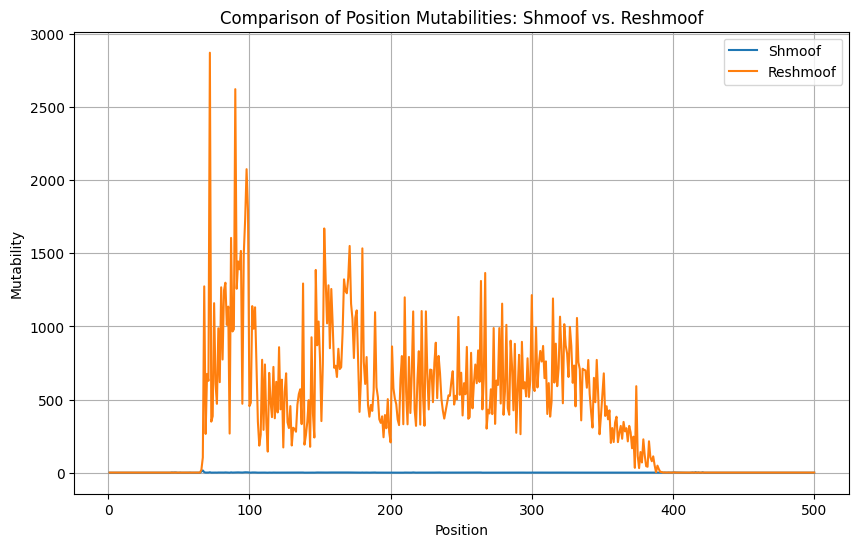

In [ ]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()
